In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
from imblearn.over_sampling import SMOTE
import pickle

In [3]:
# Load the data
df = pd.read_csv(r'D:\UCD\Spring\Data management and mining\Group Assignment\student_dataset.csv')

In [4]:
# Checking for missing values
print("\nChecking for Missing Values:")
print(df.isnull().sum())

# Checking the data types of each column
print("\nDataset Information:")
df.info()


Checking for Missing Values:
Transaction.Date      0
Transaction.Amount    0
Customer.Age          0
Account.Age.Days      0
Transaction.Hour      0
source                0
browser               0
Payment.Method        0
Product.Category      0
Quantity              0
Device.Used           0
Is.Fraudulent         0
dtype: int64

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction.Date    240000 non-null  object 
 1   Transaction.Amount  240000 non-null  float64
 2   Customer.Age        240000 non-null  int64  
 3   Account.Age.Days    240000 non-null  int64  
 4   Transaction.Hour    240000 non-null  int64  
 5   source              240000 non-null  object 
 6   browser             240000 non-null  object 
 7   Payment.Method      240000 non-null  object 
 8   Product.Category    240000 non-

In [5]:
# Preprocessing and Feature Engineering
# Convert 'Transaction.Date' to datetime and extract features
df['Transaction.Date'] = pd.to_datetime(df['Transaction.Date'], format='mixed', errors='coerce')
df['Transaction.Day'] = df['Transaction.Date'].dt.day.fillna(df['Transaction.Date'].dt.day.median())
df['Transaction.Month'] = df['Transaction.Date'].dt.month.fillna(df['Transaction.Date'].dt.month.median())
df['Transaction.Weekday'] = df['Transaction.Date'].dt.weekday.fillna(df['Transaction.Date'].dt.weekday.median())
df.drop(columns=['Transaction.Date'], inplace=True)

# Additional feature engineering
df['Amount_Binned'] = pd.qcut(df['Transaction.Amount'], q=3, labels=False, duplicates='drop')
df['Hour_Category'] = pd.cut(df['Transaction.Hour'], bins=[0, 6, 12, 18, 24], labels=False, include_lowest=True)
df['Age_Group'] = pd.cut(df['Customer.Age'], bins=[0, 25, 40, 100], labels=False, include_lowest=True)
df['Total_Spending'] = df['Transaction.Amount'] * df['Quantity']

# Encode categorical features using LabelEncoder
categorical_cols = ['source', 'browser', 'Payment.Method', 'Product.Category', 'Device.Used', 
                    'Amount_Binned', 'Hour_Category', 'Age_Group']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].fillna(df[col].mode()[0])  # Fill missing with mode for categorical
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for evaluation data

# Round Transaction.Amount to integers
df['Transaction.Amount'] = df['Transaction.Amount'].round().astype(int)

# Display processed data preview
print("\nProcessed Data Preview:")
print(df.head())


Processed Data Preview:
   Transaction.Amount  Customer.Age  Account.Age.Days  Transaction.Hour  \
0                  45            37                35                11   
1                  15            33                44                 3   
2                  54            19                44                23   
3                 234            23               107                17   
4                 412            23               220                 8   

   source  browser  Payment.Method  Product.Category  Quantity  Device.Used  \
0       0        0               0                 1         5            2   
1       1        1               3                 2         5            2   
2       2        3               3                 2         1            1   
3       0        0               1                 1         5            2   
4       0        4               1                 4         4            1   

   Is.Fraudulent  Transaction.Day  Transaction.Mo

In [6]:
# Check class distribution before resampling
fraud_counts = df['Is.Fraudulent'].value_counts()
print("\nClass Distribution Before Resampling:")
print(fraud_counts)

# Define target variable and feature set
target_column = 'Is.Fraudulent'
df[target_column] = df[target_column].astype(int)
X = df.drop(columns=[target_column])
y = df[target_column]


Class Distribution Before Resampling:
Is.Fraudulent
0    222718
1     17282
Name: count, dtype: int64


In [7]:
# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Scale the features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

D:\Projects\PycharmProjects\Ukelele\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Projects\PycharmProjects\Ukelele\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\proto\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\proto\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\proto\AppDa

In [8]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter Tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 300, 50),         # [50, 100, 150, 200, 250]
    'max_depth': [None, 10, 20, 30, 40],           # Expanded depth options
    'min_samples_split': [2, 5, 10],               # Split options
    'min_samples_leaf': [1, 2, 4],                # Leaf options
    'max_features': ['sqrt', 'log2', None],       # Feature sampling options
    'bootstrap': [True, False]                    # Bootstrapping options
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='f1', n_jobs=-1, verbose=2, random_state=42
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 50, 100, 150, 200, 250])},
                   random_state=42, scoring='f1', verbose=2)

In [9]:
# Train the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [10]:
# Evaluate the model
print("Best Hyperparameters:", random_search.best_params_)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Model Accuracy on Test Set: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")

Best Hyperparameters: {'n_estimators': np.int64(100), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
Best Model Accuracy on Test Set: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     44437
           1       0.96      0.94      0.95     44651

    accuracy                           0.95     89088
   macro avg       0.95      0.95      0.95     89088
weighted avg       0.95      0.95      0.95     89088


Confusion Matrix:
[[42527  1910]
 [ 2711 41940]]
F1 Score: 0.948


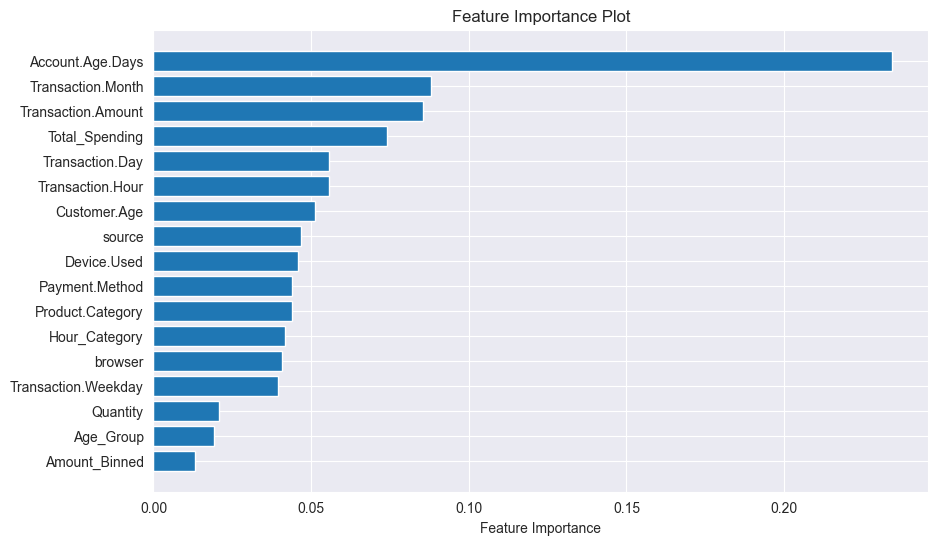

In [11]:
# Visualize Feature Importance
feature_importances = best_model.feature_importances_
features = X.columns
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.show()

In [12]:
# Save the model
filename = 'model_1.pkl'
with open(filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model saved as {filename}")

Model saved as model_1.pkl


In [13]:
# Evaluation Section (for assessment template compatibility)
# Note: This assumes 'evaluation_dataset.csv' is available; adjust path as needed
try:
    df_eval_raw = pd.read_csv('evaluation_dataset.csv')
    df_eval = df_eval_raw.copy()

    # Apply same preprocessing to evaluation data
    df_eval['Transaction.Date'] = pd.to_datetime(df_eval['Transaction.Date'], format='mixed', errors='coerce')
    df_eval['Transaction.Day'] = df_eval['Transaction.Date'].dt.day.fillna(df['Transaction.Day'].median())
    df_eval['Transaction.Month'] = df_eval['Transaction.Date'].dt.month.fillna(df['Transaction.Month'].median())
    df_eval['Transaction.Weekday'] = df_eval['Transaction.Date'].dt.weekday.fillna(df['Transaction.Weekday'].median())
    df_eval.drop(columns=['Transaction.Date'], inplace=True)

    df_eval['Amount_Binned'] = pd.qcut(df_eval['Transaction.Amount'], q=3, labels=False, duplicates='drop')
    df_eval['Hour_Category'] = pd.cut(df_eval['Transaction.Hour'], bins=[0, 6, 12, 18, 24], labels=False, include_lowest=True)
    df_eval['Age_Group'] = pd.cut(df_eval['Customer.Age'], bins=[0, 25, 40, 100], labels=False, include_lowest=True)
    df_eval['Total_Spending'] = df_eval['Transaction.Amount'] * df_eval['Quantity']

    for col in categorical_cols:
        df_eval[col] = df_eval[col].fillna(df[col].mode()[0])
        df_eval[col] = label_encoders[col].transform(df_eval[col])

    df_eval['Transaction.Amount'] = df_eval['Transaction.Amount'].round().astype(int)
    X_eval = df_eval.drop(columns=['Is.Fraudulent'])
    X_eval_scaled = scaler.transform(X_eval)
    y_eval = df_eval['Is.Fraudulent']

    # Load and test the model
    with open(filename, 'rb') as f:
        eval_model = pickle.load(f)
    y_eval_pred = eval_model.predict(X_eval_scaled)
    print("\nEvaluation on Unseen Data:")
    print(f"F1 Score: {f1_score(y_eval, y_eval_pred):.3f}")
except FileNotFoundError:
    print("Warning: 'evaluation_dataset.csv' not found. Evaluation section skipped.")